<a href="https://colab.research.google.com/github/Ibocan1999/IE423/blob/main/notebooks/task10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Electricity Load Forecasting

# INITIALIZE

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np
from datetime import datetime, timedelta

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprocessing

In [6]:
df = pd.read_csv('/content/drive/MyDrive/IE-423/continuous dataset.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48048 entries, 0 to 48047
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    48048 non-null  object 
 1   nat_demand  48048 non-null  float64
 2   T2M_toc     48048 non-null  float64
 3   QV2M_toc    48048 non-null  float64
 4   TQL_toc     48048 non-null  float64
 5   W2M_toc     48048 non-null  float64
 6   T2M_san     48048 non-null  float64
 7   QV2M_san    48048 non-null  float64
 8   TQL_san     48048 non-null  float64
 9   W2M_san     48048 non-null  float64
 10  T2M_dav     48048 non-null  float64
 11  QV2M_dav    48048 non-null  float64
 12  TQL_dav     48048 non-null  float64
 13  W2M_dav     48048 non-null  float64
 14  Holiday_ID  48048 non-null  int64  
 15  holiday     48048 non-null  int64  
 16  school      48048 non-null  int64  
dtypes: float64(13), int64(3), object(1)
memory usage: 6.2+ MB


In [8]:
df.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [9]:
df.shape

(48048, 17)

In [10]:
df.isnull().sum()

,0
datetime,0
nat_demand,0
T2M_toc,0
QV2M_toc,0
TQL_toc,0
W2M_toc,0
T2M_san,0
QV2M_san,0
TQL_san,0
W2M_san,0


In [ ]:
numerical_features

['nat_demand',
 'T2M_toc',
 'QV2M_toc',
 'TQL_toc',
 'W2M_toc',
 'T2M_san',
 'QV2M_san',
 'TQL_san',
 'W2M_san',
 'T2M_dav',
 'QV2M_dav',
 'TQL_dav',
 'W2M_dav',
 'Holiday_ID',
 'holiday',
 'school']

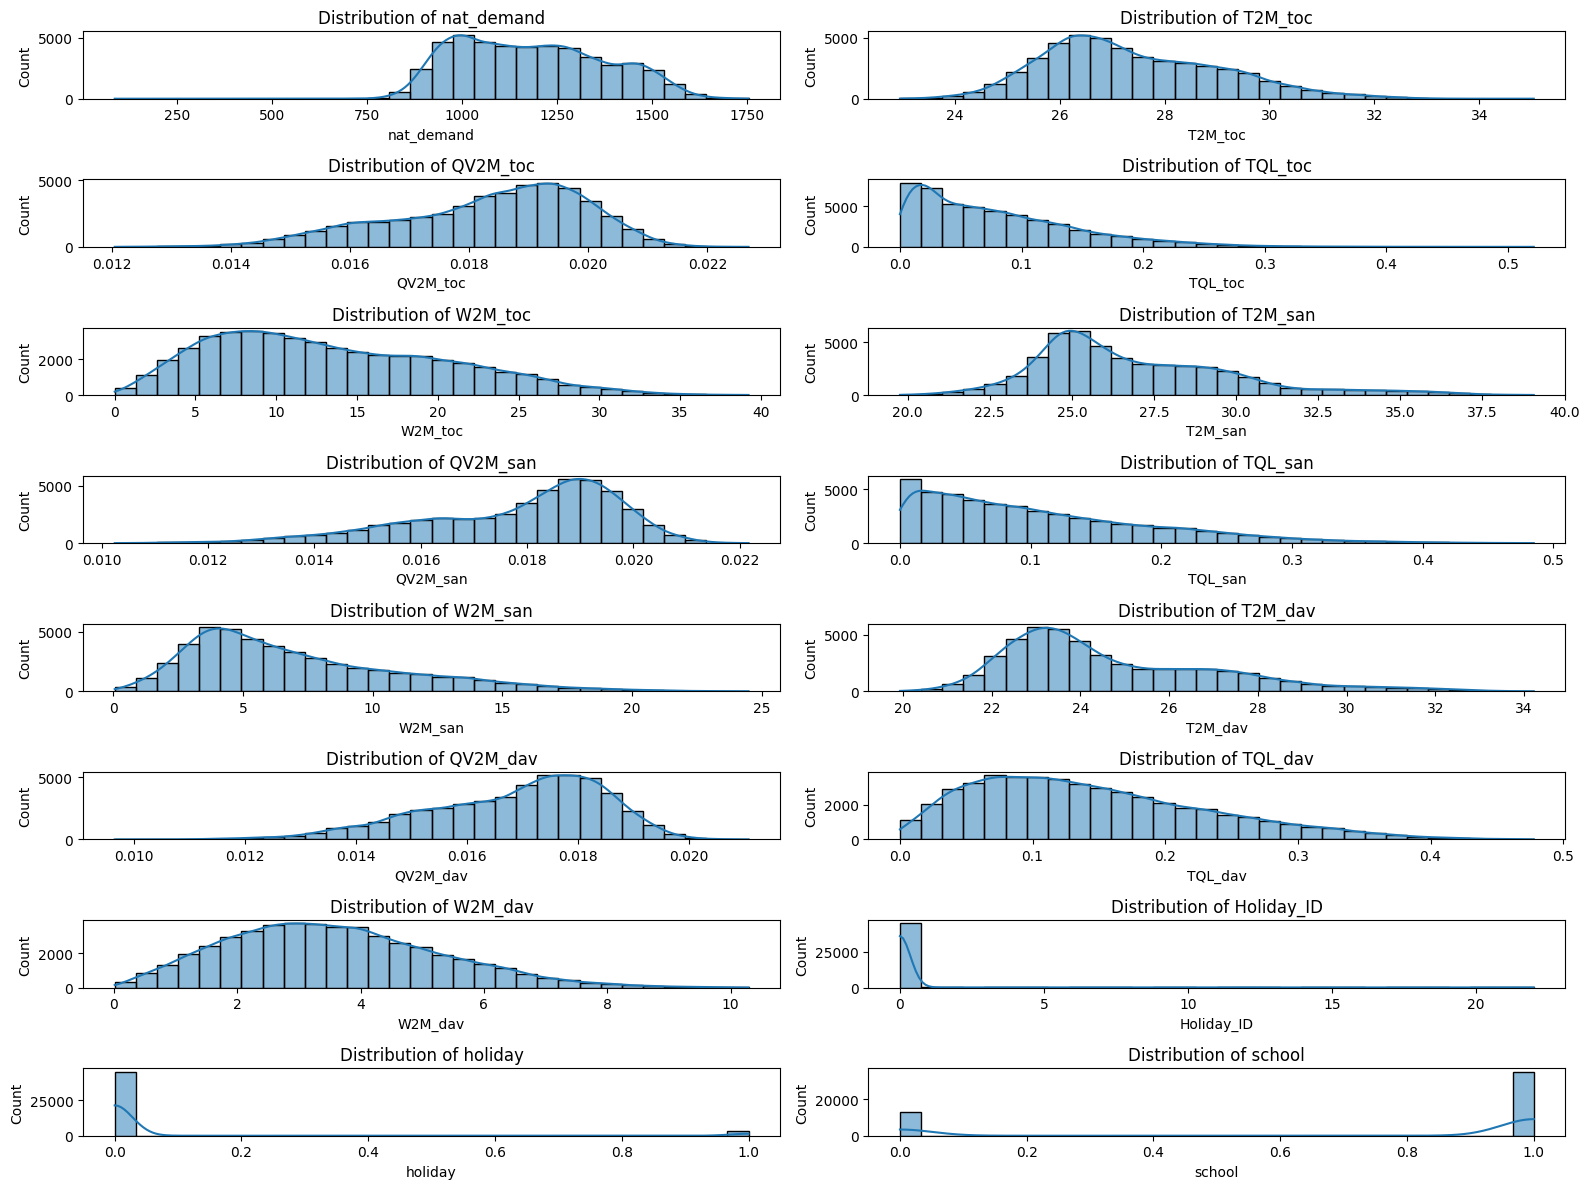

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_features = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]

num_rows = (len(numerical_features) + 1) // 2

plt.figure(figsize=(16, 12))

# Plot histograms for numerical features
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(num_rows, 2, i)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()

In [22]:
# Re-apply the create_features function to add the new features without removing existing columns
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype('category')
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week  # Use isocalendar().week
    df['date_offset'] = (df.date.dt.month * 100 + df.date.dt.day - 320) % 1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], labels=['Spring', 'Summer', 'Fall', 'Winter'])
    if label:
        y = df[label]
        return df, y
    return df

# Apply the create_features function to the dataframe con_df without removing existing columns
df_featured, y = create_features(df, label='nat_demand')
df_featured.head()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,...,dayofweek,weekday,quarter,month,year,dayofyear,dayofmonth,weekofyear,date_offset,season
datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,...,5,Saturday,1,1,2015,3,3,1,1083,Winter
2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,...,5,Saturday,1,1,2015,3,3,1,1083,Winter
2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,...,5,Saturday,1,1,2015,3,3,1,1083,Winter
2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,...,5,Saturday,1,1,2015,3,3,1,1083,Winter
2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,...,5,Saturday,1,1,2015,3,3,1,1083,Winter


# Exploratory Data Analysis: Visual Overview of Denmark's Electricity Data
# GrossCon' Patterns and Discrepancies

Text(0, 0.5, 'National Demand')

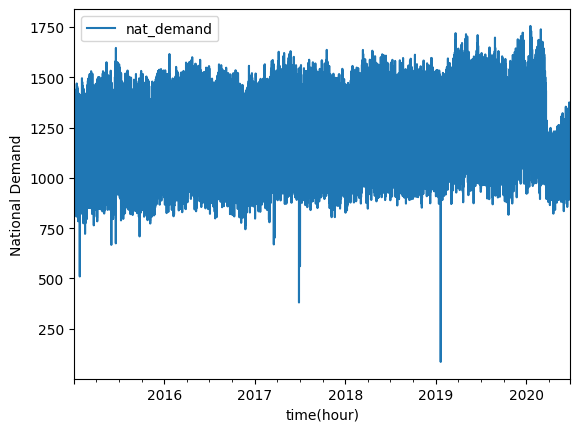

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Make sure pandas is imported

# Assuming 'datetime' is the column with datetime values
df['datetime'] = pd.to_datetime(df['datetime']) # Convert 'datetime' column to datetime objects
df.set_index('datetime', inplace=True) # Set 'datetime' column as index

df[['nat_demand']]['2015-01-03': '2020-06-27'].plot()

plt.xlabel('time(hour)')
plt.ylabel('National Demand')

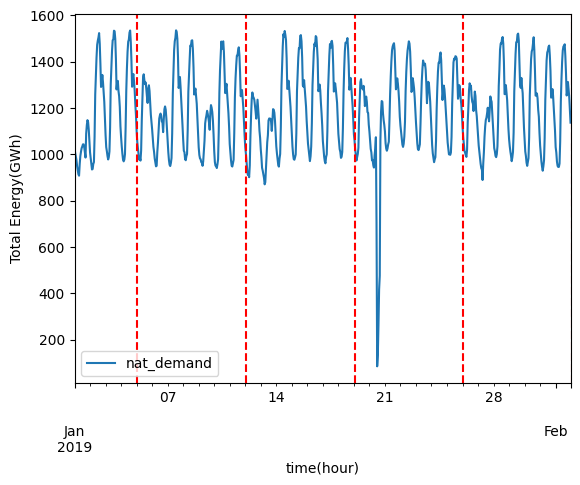

In [18]:
df[['nat_demand' ]]['2019-01-01': '2019-02-01'].plot()

plt.xlabel('time(hour)')
plt.ylabel('Total Energy(GWh)')

# Adding vertical lines at the start of each week
min_date, max_date = df.index.min(), df.index.max()
current_date = min_date

while current_date <= max_date:
    if current_date.weekday() == 5:  # Monday is considered the start of the week
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

# Computing Autocorrelation for the 'GrossCon' Column

Text(0.5, 1.0, 'ACF Plot with Marked Peak at x=24 hours')

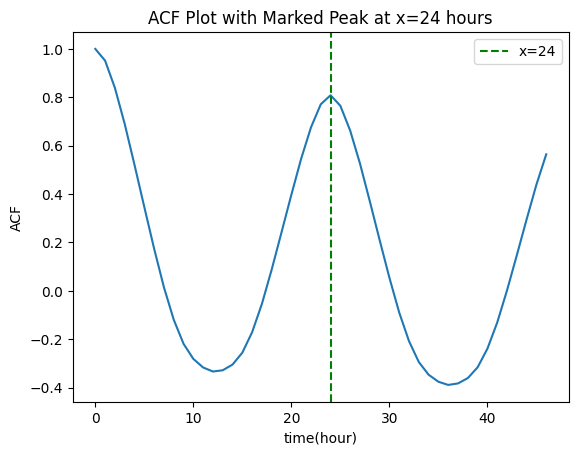

In [19]:
plt.plot(acf(df['nat_demand']))
plt.xlabel('time(hour)')
plt.ylabel('ACF')
plt.axvline(x=24, color='green', linestyle='--', label='x=24')

plt.legend()
plt.title('ACF Plot with Marked Peak at x=24 hours')

Text(0, 0.5, 'Temperature by city')

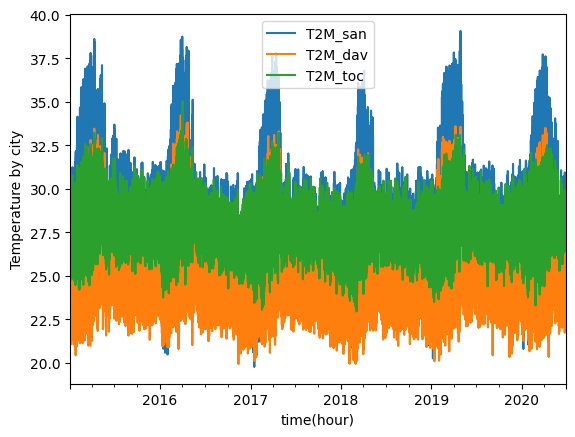

In [20]:
df[['T2M_san', 'T2M_dav', 'T2M_toc']]['2015-01-03': '2020-06-27'].plot()
plt.xlabel('time(hour)')
plt.ylabel('Temperature by city')

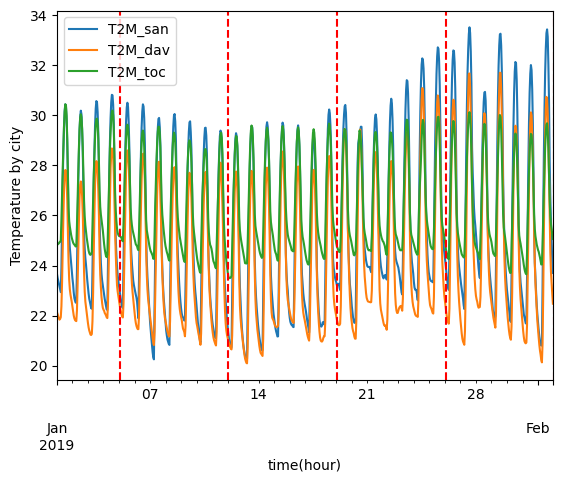

In [29]:
df[['T2M_san', 'T2M_dav', 'T2M_toc']]['2019-01-01': '2019-02-01'].plot()
plt.xlabel('time(hour)')
plt.ylabel('Temperature by city')

# Adding vertical lines at the start of each week
min_date, max_date = df.index.min(), df.index.max()
current_date = min_date

while current_date <= max_date:
    if current_date.weekday() == 5:  # Monday is considered the start of the week
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

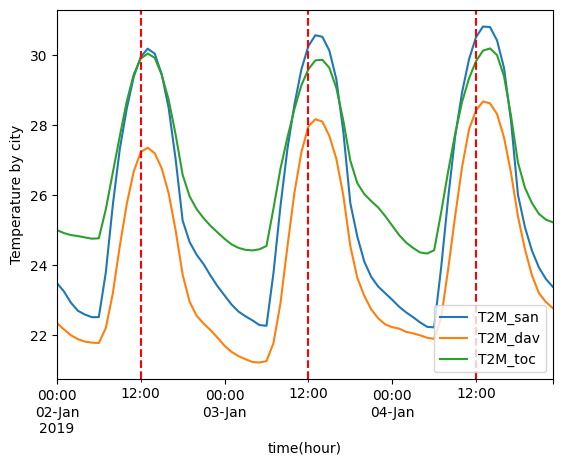

In [27]:
df[['T2M_san', 'T2M_dav', 'T2M_toc']]['2019-01-02': '2019-01-04'].plot()
plt.xlabel('time(hour)')
plt.ylabel('Temperature by city')

# Adding vertical lines at the start of each week
min_date, max_date = df.index.min(), df.index.max()
current_date = min_date

while current_date <= max_date:
    if current_date.hour == 12:  # Monday is considered the start of the week
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(hours=1)

# Wind Speed by city

Text(0, 0.5, 'Wind Speed by city')

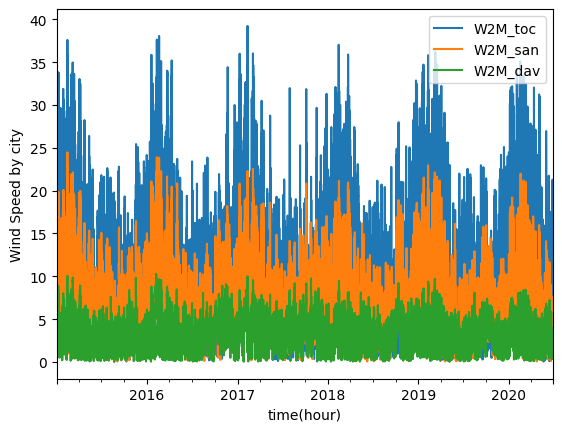

In [30]:
df[[ 'W2M_toc', 'W2M_san', 'W2M_dav']]['2015-01-03': '2020-06-27'].plot()
plt.xlabel('time(hour)')
plt.ylabel('Wind Speed by city')

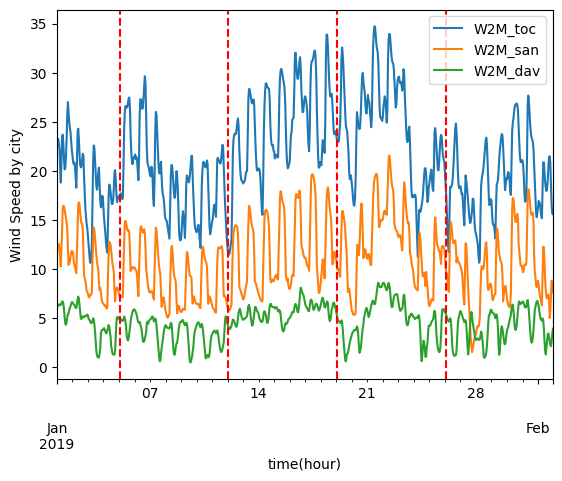

In [35]:
df[['W2M_toc', 'W2M_san', 'W2M_dav']]['2019-01-01': '2019-02-01'].plot()
plt.xlabel('time(hour)')
plt.ylabel('Wind Speed by city')


# Adding vertical lines at the start of each week
min_date, max_date = df.index.min(), df.index.max()
current_date = min_date

while current_date <= max_date:
    if current_date.weekday() == 5:  # Monday is considered the start of the week
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

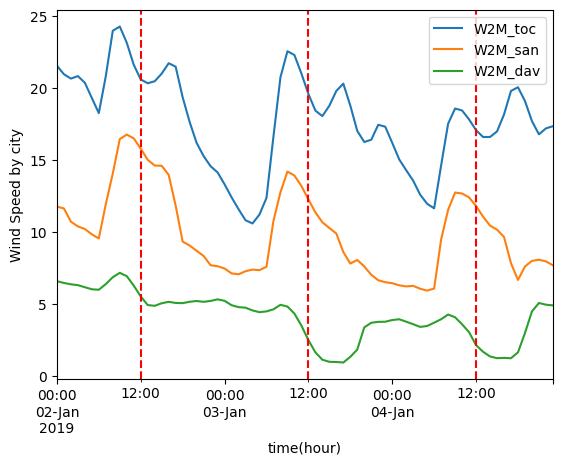

In [37]:
df[[ 'W2M_toc', 'W2M_san', 'W2M_dav']]['2019-01-02': '2019-01-04'].plot()
plt.xlabel('time(hour)')
plt.ylabel('Wind Speed by city')

# Adding vertical lines at midday
min_date, max_date = df.index.min(), df.index.max()
current_date = min_date

while current_date <= max_date:
    if current_date.hour == 12:  # Mid day
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(hours=1)

# Humidty Average and Demand

Text(0, 0.5, 'Wind Speed by city')

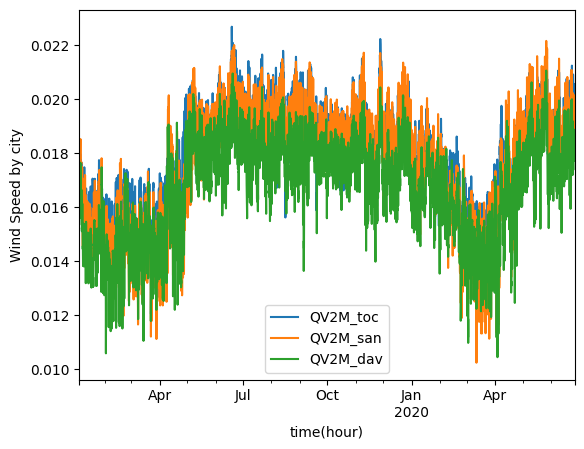

In [38]:
df[[ 'QV2M_toc', 'QV2M_san', 'QV2M_dav']]['2019-01-03': '2020-06-27'].plot()
plt.xlabel('time(hour)')
plt.ylabel('Wind Speed by city')

In [ ]:
# Resample the data to ensure an hourly frequency
con_df_resampled = con_df_featured.resample('H').sum()

# Set the frequency of the index column to hourly
con_df_resampled.index.freq = 'H'

# Display the first few rows of the resampled dataframe
con_df_resampled.head()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,...,dayofweek,weekday,quarter,month,year,dayofyear,dayofmonth,weekofyear,date_offset,season
datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,...,5,2,1,1,2015,3,3,1,1083,3
2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,...,5,2,1,1,2015,3,3,1,1083,3
2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,...,5,2,1,1,2015,3,3,1,1083,3
2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,...,5,2,1,1,2015,3,3,1,1083,3
2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,...,5,2,1,1,2015,3,3,1,1083,3


# Modeling

## Augmented Dickey-Fuller Test

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a given time series is stationary or non-stationary.

In [41]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    """
    Perform ADF test on the given time series and print a comprehensive report.
    """
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'Augmented Dickey-Fuller Test: {title}')
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', '# Observations']
    out = dict(zip(labels, result[:4]))
    for key, val in out.items():
        print(f'{key} : {val}')

    print('Critical Values:')
    for key, val in result[4].items():
        print(f'   {key} : {val}')

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

# Apply the ADF test on the 'nat_demand' column to assess its stationarity
adf_test(df['nat_demand'], title='National Electricity Load (nat_demand)')


Augmented Dickey-Fuller Test: National Electricity Load (nat_demand)
ADF Test Statistic : -20.96175000729656
p-value : 0.0
# Lags Used : 57
# Observations : 47990
Critical Values:
   1% : -3.430486271094305
   5% : -2.861600228969454
   10% : -2.5668020578981667
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Given the extremely low p-value and the ADF test statistic being lower than all critical values, we reject the null hypothesis. This implies that there is strong evidence against the presence of a unit root.

Stationarity is a crucial assumption for many time series models, including ARIMA and its variants. When a series is stationary, it means that the underlying data generation process is stable over time, making it easier to model and predict future values. Non-stationary data, on the other hand, can have trends, seasonality, or other structures that complicate modeling.

Now Let's proceed

**Data Splitting**

In [45]:
# Printing the maximum timestamp in the dataset
print(df.index.max())

# Printing the minimum timestamp in the dataset
print(df.index.min())

2020-06-27 00:00:00
2015-01-03 01:00:00


In [49]:
dev_date_str = '2019-05-31'
# Convert dev_date_str to a datetime object
dev_date = datetime.strptime(dev_date_str, '%Y-%m-%d')
dev_date = pd.Timestamp(dev_date, tz='UTC')


df.index = df.index.tz_localize('UTC')

# Splitting the data into training and testing sets
train_data = df[:dev_date]
test_data = df[dev_date:]

## Exponential Smoothing

Exponential smoothing is a technique for forecasting time series data that calculates future values by averaging past observations with weights that decrease exponentially.

In [50]:
fitted_model = ExponentialSmoothing(train_data['nat_demand'],
                                    trend='add',
                                    seasonal='add',
                                    seasonal_periods=24).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [51]:
# Set the number of days for which the prediction is to be made
number_of_days = 393

# Calculate the total number of hours to predict based on the number of days
number_of_hours_to_predict = number_of_days * 24

# Calculate the end date for the prediction by adding the total hours to the development date (dev_date)
end_date = dev_date + timedelta(hours=number_of_hours_to_predict - 1)

# Extract the actual Gross Consumption data from the test dataset for the specified period
y = test_data['nat_demand'][dev_date:end_date]

# Use the fitted model to forecast the values for the specified number of hours and rename the output series to 'HW_Forecast'
test_predictions = fitted_model.forecast(number_of_hours_to_predict).rename('HW_Forecast')

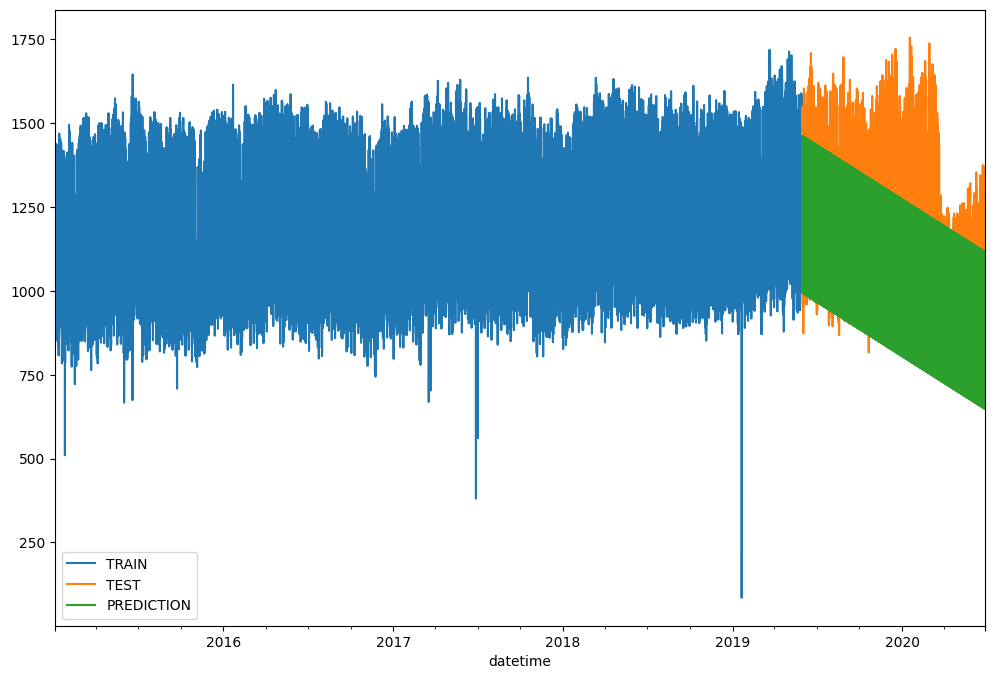

In [52]:
# Plotting the Gross Consumption from the training data
train_data['nat_demand'].plot(legend=True, label='TRAIN')

# Plotting the Gross Consumption from the test data
test_data['nat_demand'].plot(legend=True, label='TEST', figsize=(12,8))

# Plotting the predicted Gross Consumption values
test_predictions.plot(legend=True, label='PREDICTION');

<Axes: xlabel='datetime'>

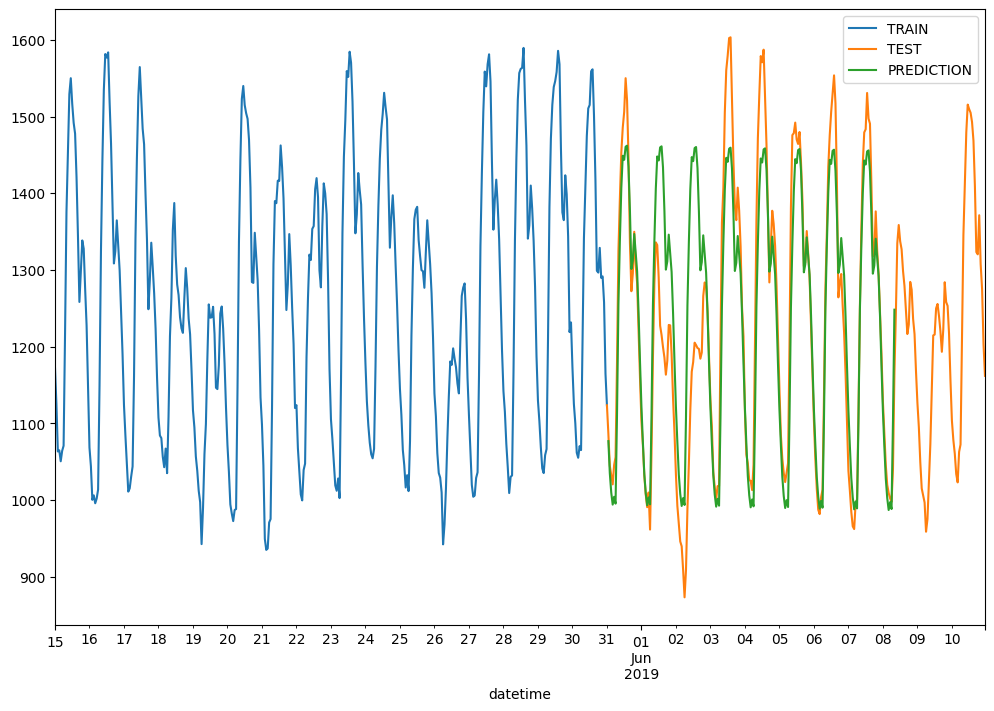

In [53]:
# Plotting the training data
train_data['nat_demand']['2019-05-15':].plot(legend=True, label='TRAIN')

# Plotting the testing data
test_data['nat_demand'][:'2019-06-10'].plot(legend=True, label='TEST', figsize=(12, 8))

# Plotting the predictions (first 200 points)
test_predictions[:200].plot(legend=True, label='PREDICTION')

In [55]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y, test_predictions)
print("Mean Absolute Error:", mae)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y, test_predictions)
print("Mean Squared Error:", mse)

Mean Absolute Error: 164.17443148709918
Mean Squared Error: 39245.745519816235


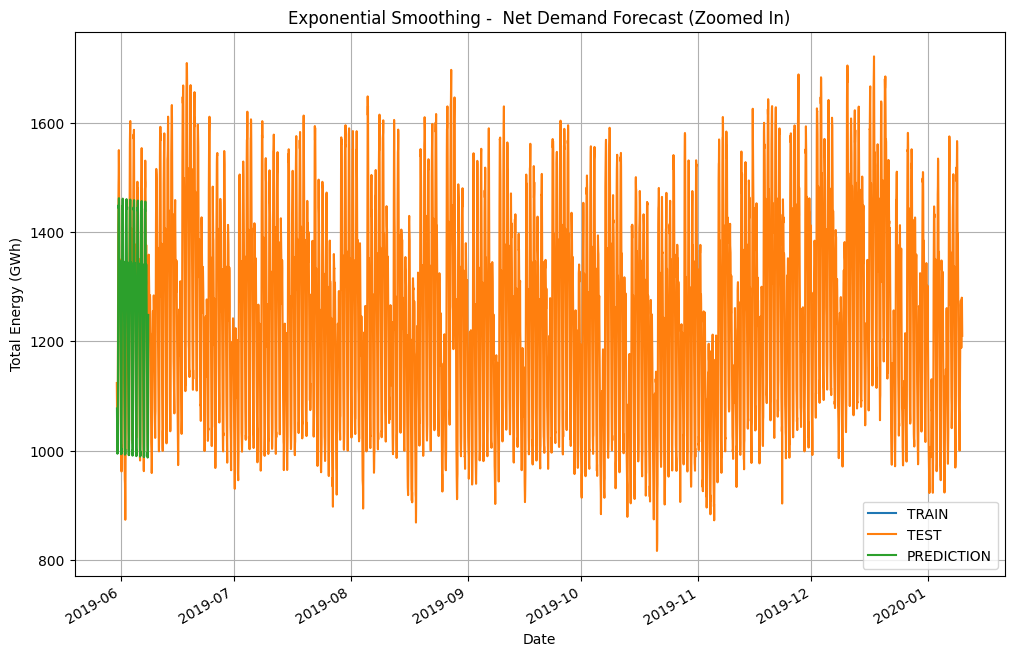

In [56]:
# Zoom in on the plot to get a clearer comparison

train_data['nat_demand']['2019-12-31':].plot(legend=True, label='TRAIN')

test_data['nat_demand'][:'2020-01-9'].plot(legend=True, label='TEST', figsize=(12, 8))

# Plotting the first 200 points of the predictions
test_predictions[:200].plot(legend=True, label='PREDICTION')

plt.title('Exponential Smoothing -  Net Demand Forecast (Zoomed In)')
plt.xlabel('Date')
plt.ylabel('Total Energy (GWh)')
plt.grid(True)
plt.show()


## Autoregression (AR) Model

The Autoregressive (AR) model, combined with the Moving-Average (MA) model, forms a special case and a fundamental part of the broader Autoregressive-Moving-Average (ARMA) and Autoregressive Integrated Moving-Average (ARIMA) models used in time series analysis.

The AR model represents a type of random process and can describe various time-varying phenomena in fields like nature, economics, and behavior. It defines the output variable as a linear function of its past values plus a stochastic term, which accounts for random deviations. This model is expressed as a stochastic difference equation, not to be confused with a differential equation.


In [58]:
# Importing the Autoregression model from statsmodels library
from statsmodels.tsa.ar_model import AutoReg,ARResults
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
model = AutoReg(train_data['nat_demand'], lags=1)
ARfit = model.fit()
ARfit.params

,0
const,58.691005
nat_demand.L1,0.950099


In [59]:
# This is the general format for obtaining predictions
start=len(train_data['nat_demand'])
end=len(train_data['nat_demand'])+len(test_data['nat_demand'])-1
predictions1 = ARfit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

<Axes: xlabel='datetime'>

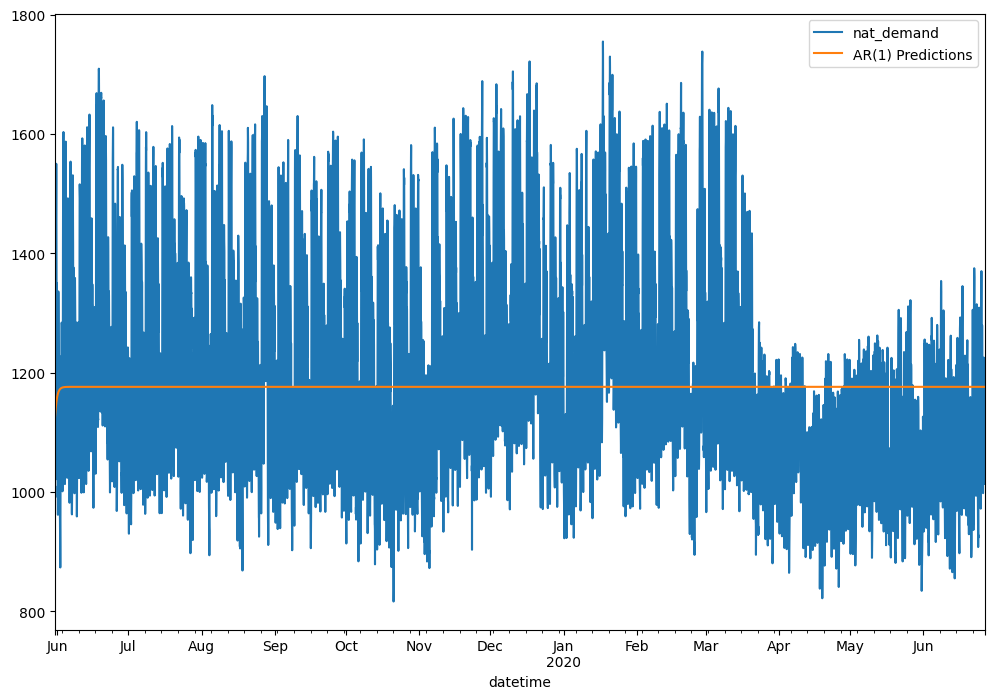

In [60]:
test_data['nat_demand'].plot(figsize=(12, 8), legend=True)
predictions1.plot(figsize=(12, 8), legend=True)

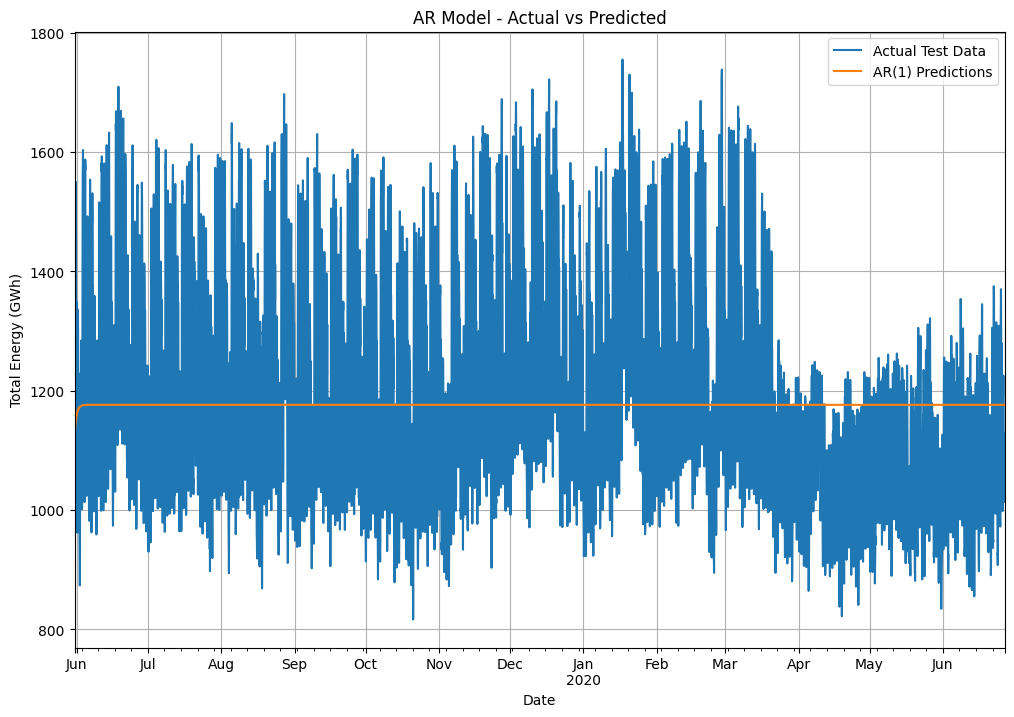

In [61]:
import matplotlib.pyplot as plt

# Plotting the actual test data
test_data['nat_demand'].plot(figsize=(12, 8), legend=True, label='Actual Test Data')

# Plotting the predictions from the AR model
predictions1.plot(figsize=(12, 8), legend=True, label='AR(1) Predictions')

plt.title('AR Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Total Energy (GWh)')
plt.grid(True)
plt.show()

## Seasonal Autoregressive Integrated Moving Average (SARIMA) Model


SARIMA is an extension of the non-seasonal ARIMA model, tailored to handle data with seasonal variations. It addresses both short-term and long-term dependencies in the data, making it a powerful forecasting tool. SARIMA integrates autoregressive (AR), integrated (I), and moving average (MA) models with seasonal elements.

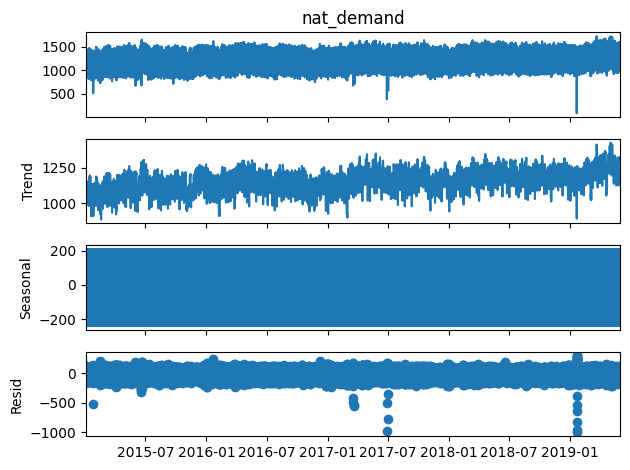

In [63]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_data['nat_demand'], model='additive')  # model='add' also works
result.plot();

Residuals indicate the variability left in the data after accounting for trend and seasonal components. They reflect the noise or irregular fluctuations in the data, and there are some noticeable outliers present.

The trend component exhibits a generally stable pattern, with occasional periods of increase and decrease.

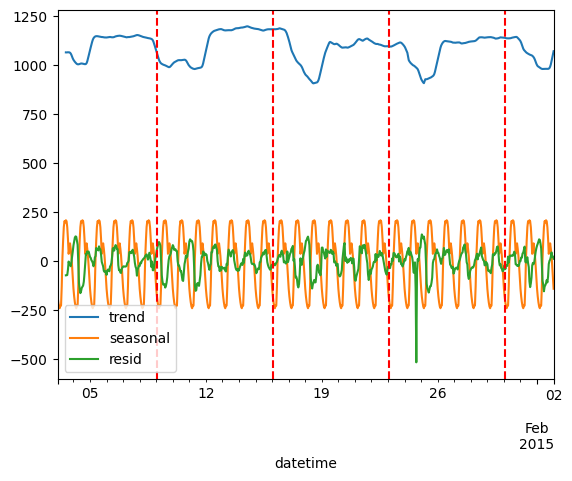

In [64]:
n_days = 30
n = 24 * n_days
# To plot the first n points of the trend component
result.trend[:n].plot(legend=True);

# To plot the first n points of the seasonal component
result.seasonal[:n].plot(legend=True);

# To plot the first n points of the residual component
result.resid[:n].plot(legend=True);

# Adding vertical lines at the start of each week
min_date, max_date = train_data.index.min(), train_data.index.max()
current_date = min_date

while current_date <= max_date:
    if current_date.weekday() == 4:  # Monday is considered the start of the week
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

<Axes: xlabel='datetime'>

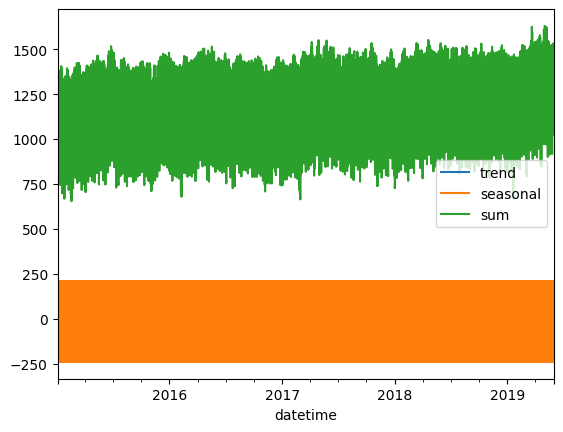

In [65]:
decomp_data = {}
decomp_data['trend'] = result.trend
decomp_data['seasonal'] = result.seasonal
df_decom_data = pd.DataFrame(decomp_data)
df_decom_data['sum'] = df_decom_data['trend'] + df_decom_data['seasonal']
df_decom_data.plot()

In [66]:
df_decom_data.head()

,trend,seasonal,sum
datetime,,,
2015-01-03 01:00:00+00:00,NaN,-178.991487,NaN
2015-01-03 02:00:00+00:00,NaN,-208.433649,NaN
2015-01-03 03:00:00+00:00,NaN,-229.523615,NaN
2015-01-03 04:00:00+00:00,NaN,-239.101343,NaN
2015-01-03 05:00:00+00:00,NaN,-225.564449,NaN


# Automated ARIMA Model Selection with pmdarima

In [71]:
# Importing the `auto_arima` function from `pmdarima` library
!pip install pmdarima
from pmdarima import auto_arima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.2 MB/s eta 0:00:00


In [72]:
# Using auto_arima to automatically select the best ARIMA model for 'GrossCon' time series data

# Data input: 'GrossCon' time series data (first 1000 data points)
stepwise_fit = auto_arima(df['nat_demand'][:500],

                          # Starting values for ARIMA orders
                          start_p=0,  # Autoregressive order (p)
                          start_q=0,  # Moving average order (q)

                          # Maximum allowable ARIMA orders
                          max_p=3,  # Maximum autoregressive order (p)
                          max_q=3,  # Maximum moving average order (q)

                          # Seasonality information (24-hour seasonality)
                          m=24,  # Number of time steps in a seasonal cycle

                          # Enable seasonal decomposition
                          seasonal=True,

                          # Differencing order (None implies automatic differencing)
                          d=None,

                          # Display progress information during model search
                          trace=True,

                          # Behavior when an order doesn't work (ignore errors)
                          error_action='ignore',

                          # Suppress convergence warnings
                          suppress_warnings=True,

                          # Use the stepwise search approach for efficiency
                          stepwise=True)


stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=6259.356, Time=13.08 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=6621.700, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=18.00 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=5797.247, Time=10.91 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=8434.955, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=6005.168, Time=1.66 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=5797.939, Time=14.54 sec
 ARIMA(0,0,1)(0,0,2)[24] intercept   : AIC=5675.693, Time=53.85 sec
 ARIMA(0,0,1)(1,0,2)[24] intercept   : AIC=5679.311, Time=52.53 sec
 ARIMA(0,0,0)(0,0,2)[24] intercept   : AIC=6242.280, Time=10.53 sec
 ARIMA(1,0,1)(0,0,2)[24] intercept   : AIC=4911.569, Time=20.78 sec
 ARIMA(1,0,1)(0,0,1)[24] intercept   : AIC=5009.431, Time=8.12 sec
 ARIMA(1,0,1)(1,0,2)[24] intercept   : AIC=4726.761, Time=25.87 sec
 ARIMA(1,0,1)(1,0,1)[24] intercept   : AIC=4699.180, Time=9.50 sec
 ARIMA(1,0,1)(1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  500
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 24)   Log Likelihood               -2335.539
Date:                              Wed, 07 Aug 2024   AIC                           4685.079
Time:                                      18:21:06   BIC                           4714.581
Sample:                                  01-03-2015   HQIC                          4696.655
                                       - 01-23-2015                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.5657      1.939      3.386      0.001       2.765      10.367
ar.L1          0.8892      0.017     51.905      0.000       0.856       0.923
ma.L1          0.4751      0.038     12.659      0.000       0.402       0.549
ma.L2          0.2485      0.042      5.928      0.000       0.166       0.331
ar.S.L24       0.9441      0.012     76.680      0.000       0.920       0.968
ma.S.L24      -0.6480      0.039    -16.732      0.000      -0.724      -0.572
sigma2       599.8471     29.054     20.646      0.000     542.902     656.792
===================================================================================
Ljung-Box (L1) (Q):                   2.17   Jarque-Bera (JB):                95.68
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                             0.19
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='datetime'>

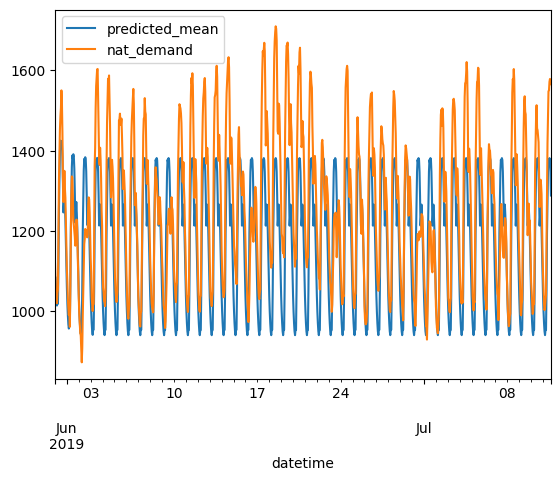

In [73]:
# Import the necessary library
import statsmodels.api as sm

# Create the ARIMA model with the selected parameters
model = sm.tsa.ARIMA(train_data['nat_demand'], order=(1, 0, 2), seasonal_order=(1, 0, 1, 24), enforce_stationarity=False)

# Fit the ARIMA model to the data
model_fit = model.fit()
# Make future predictions
forecasted_values = model_fit.forecast(1000)
forecasted_values.plot(legend=True)
test_data['nat_demand'][:1000].plot(legend=True)

In [76]:
mae = mean_absolute_error(test_data['nat_demand'][:1000], forecasted_values)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(test_data['nat_demand'][:1000], forecasted_values)
print("Mean Squared Error:", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 118.60493418457493
Mean Squared Error: 19848.414734119757
Root Mean Squared Error: 140.8844020256315


# Using the seasonal decomposed data as exogenic parameter in SARIMA.

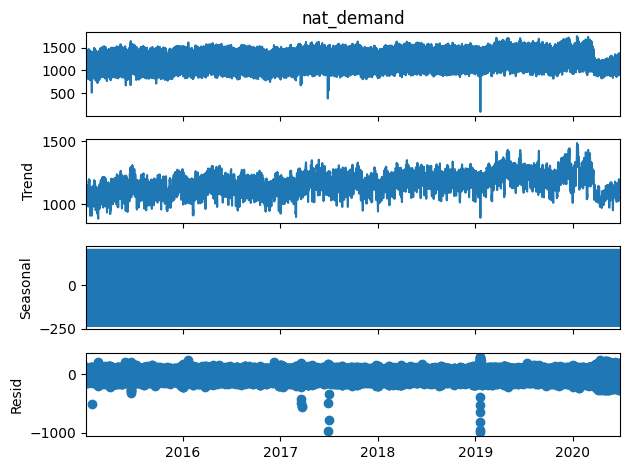

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['nat_demand'], model='additive')  # model='add' also works
result.plot();

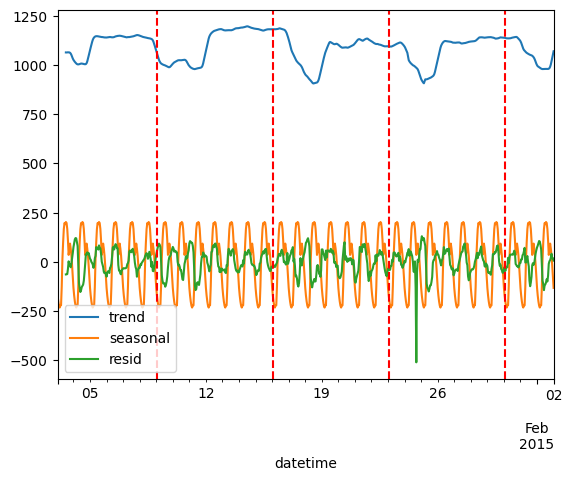

In [81]:
n_days = 30
n = 24 * n_days
# To plot the first n points of the trend component
result.trend[:n].plot(legend=True);

# To plot the first n points of the seasonal component
result.seasonal[:n].plot(legend=True);

# To plot the first n points of the residual component
result.resid[:n].plot(legend=True);

# Adding vertical lines at the start of each week
min_date, max_date = df.index.min(), df.index.max()
current_date = min_date

while current_date <= max_date:
    if current_date.weekday() == 4:  # Monday is considered the start of the week
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

<Axes: xlabel='datetime'>

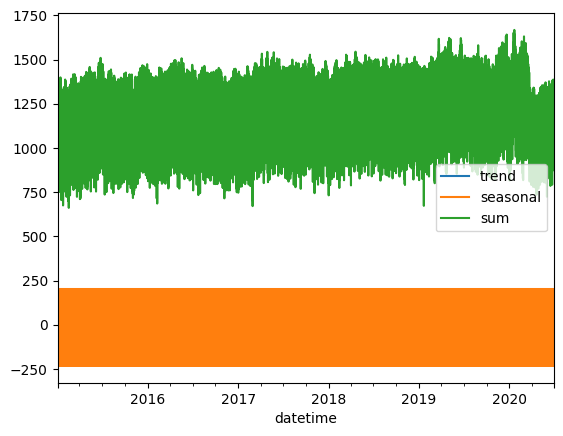

In [82]:
decomp_data = {}
decomp_data['trend'] = result.trend
decomp_data['seasonal'] = result.seasonal
df_decom_data = pd.DataFrame(decomp_data)
df_decom_data['sum'] = df_decom_data['trend'] + df_decom_data['seasonal']
df_decom_data.plot()

In [83]:
df_decom_data.head()

,trend,seasonal,sum
datetime,,,
2015-01-03 01:00:00+00:00,NaN,-171.887459,NaN
2015-01-03 02:00:00+00:00,NaN,-201.678198,NaN
2015-01-03 03:00:00+00:00,NaN,-223.106475,NaN
2015-01-03 04:00:00+00:00,NaN,-232.980741,NaN
2015-01-03 05:00:00+00:00,NaN,-220.058009,NaN


<Axes: xlabel='datetime'>

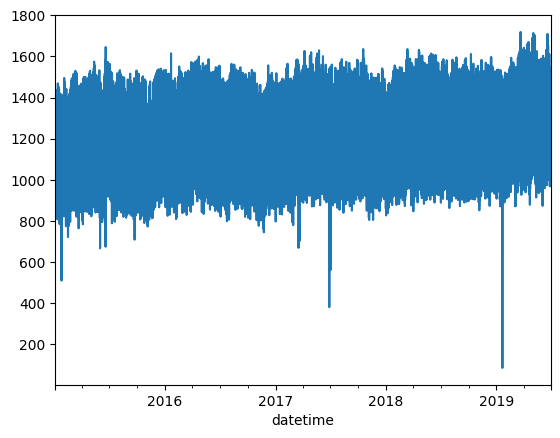

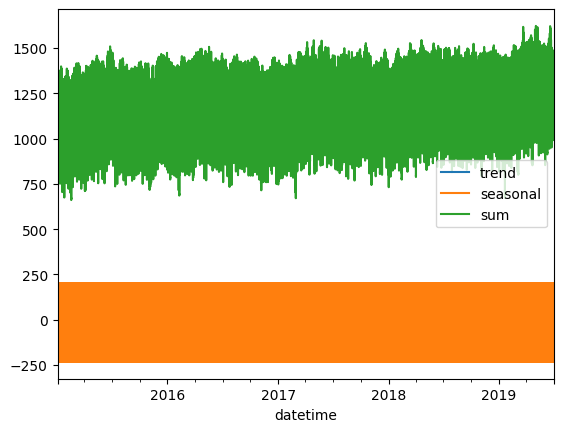

In [85]:
dev_date_str = '2019-06-30'
# Convert dev_date_str to a datetime object
dev_date = datetime.strptime(dev_date_str, '%Y-%m-%d')
dev_date = pd.Timestamp(dev_date, tz='UTC')
train_data_exo = df[:dev_date]
test_data_exo = df[dev_date:]

df_decom_data_train = df_decom_data[:dev_date]
train_data_exo['nat_demand'].plot()
df_decom_data_train.plot()

In [87]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

index = - 200

model = SARIMAX(train_data_exo['nat_demand'][index:],
                exog=df_decom_data_train[index:],
                order=(1, 0, 2),
                seasonal_order=(1, 0, 1, 24),
                enforce_invertibility=False)
results = model.fit()
results.summary()

KeyboardInterrupt: 